# Autoregressive model for Time Series

In [ ]:
import os
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

np.random.seed(1234)
stan_seed = 1234

2021-11-23 08:11:51.960349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 08:11:51.960384: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import Data

We consider data from the Open Power System Data (OPSD) for Germany, which has been rapidly expanding its renewable energy production in recent years.

The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017

         Date  Consumption  Wind  Solar  Wind+Solar
0  2006-01-01     1069.184   NaN    NaN         NaN
1  2006-01-02     1380.521   NaN    NaN         NaN
2  2006-01-03     1442.533   NaN    NaN         NaN
3  2006-01-04     1457.217   NaN    NaN         NaN
4  2006-01-05     1477.131   NaN    NaN         NaN


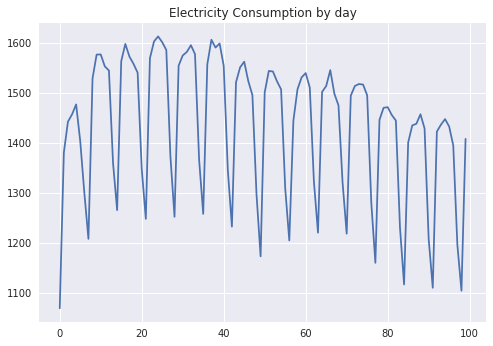

In [ ]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url,sep=",")
print(df.head())

data = df['Consumption'][:100].values

plt.plot(data)
plt.title('Electricity Consumption by day')
plt.show()

## Autoregressive Model

An Autoregressive model of order $p$ is:
\begin{equation*}
\begin{aligned}
    y_t &= \alpha + \sum_{j=1}^{p} \phi_j y_{t-j} + \epsilon_j  \;\;\;\;\; t=1,...,N \\
    \epsilon_t & \overset{\text{iid}}{\sim} \mathcal{N}(0, \sigma^2) \;\;\;\;\; t=1,...,N
\end{aligned}   
\end{equation*}
$\newline$
i.e. the likelihood of the observed data $y_t$ is:
\begin{equation*}
\begin{aligned}
    \mu_t & = \alpha + \sum_{j=1}^{p} \phi_j y_{t-j}  \;\;\;\;\; t=1,...,N \\
    y_t & \sim \mathcal{N}(\mu_t, \sigma^2) \;\;\;\;\; t=1,...,N  
\end{aligned}   
\end{equation*}
$\newline$

We set as priors for the parameters of the AR model:

\begin{equation*}
\begin{aligned}
    \alpha & \sim \mathcal{N}(\mu_{\alpha}, \sigma^2_{\alpha})  \\
    \phi_j & \overset{\text{iid}}{\sim} \mathcal{N}(0, \sigma^2_{\phi}) \;\;\;\;\; j=1,...,p  \\
    \sigma & \sim \mathcal{HC}(0, 1)
\end{aligned}   
\end{equation*}
$\newline$ 
with hyper-parameters $\mu_{\alpha} = 1400$, $\sigma_{\alpha} = 100$ and $\sigma_{\phi} = 25$

## Stan code for Autoregressive Model

In [ ]:
ar_p = """
    data {
      int<lower=0> N;         // number of observations of the time series
      int<lower=0> p;         // order of the autoregressive model
      vector[N] y;            // vector collecting the observations of the time series
      int<lower=0> N_pred;    // number of future predictions of the time series
    }
    
    parameters {
      real alpha;             // coefficient alpha (intercept of model)
      real phi[p];            // coefficients phi_j of the sum
      real<lower=0> sigma;    // sigma coefficient
    }
    
    model {
      for (n in (p+1):N) {
        real mu = alpha;               // set the current average
        for (k in 1:p) { 
          mu += phi[k] * y[n-k];       // sum of the previous terms of the autoregressive model
        }
        y[n] ~ normal(mu, sigma);      // likelihood of observations
      }
      
      alpha ~ normal(1400, 100);       // prior of alpha
      phi ~ normal(0, 25);             // prior of phi coefficients
      sigma ~ cauchy(0, 1);            // prior of sigma
    }
    
    
    generated quantities {                       // vector containing the fitted values in the time range of
        vector[N + N_pred] y_pred;                   // the time series + space for following next 50 predictions             
        y_pred[1:N] = y;                         // collect the observed data in the time range of the series
        for (i in 1:N_pred) {
            real mu = alpha;
            for (k in 1:p) {
              mu += phi[k] * y_pred[N + i - k];     // build the autoregressive model
            }
            y_pred[N + i] = normal_rng(mu, sigma);  // perform the prediction according to the AR model
        }
}
    
"""

stan_file = "./ar_p.stan"

with open(stan_file, "w") as f:
    print(ar_p, file=f)

ar_p = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /home/carlo/projects/bayesian_stat/my_implementations/Time_Series_Autoregressive_Stan/ar_p
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/carlo/projects/bayesian_stat/my_implementations/Time_Series_Autoregressive_Stan/ar_p


## Autoregressive order 1

### Settings

In [ ]:
N_pred = 50
ar1_data = {
    "N": len(data),
    "p": 1,            # order 1
    "y": data,
    "N_pred": N_pred   # number of predictions
}
N_iter = 1000
ar_1_fit = ar_p.sample(data=ar1_data, chains=4, parallel_chains=4, seed=stan_seed,
    iter_warmup=1000, iter_sampling=N_iter, thin = 1, show_progress=True)

ar1_fit_data = az.from_cmdstanpy(ar_1_fit)

Chain 2 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                        | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                        | 0/2000 [00:00<?, ?it/s]


Chain 2 - warmup:  15%|█████████                                                   | 300/2000 [00:00<00:00, 2728.17it/s]

Chain 3 - warmup:  30%|██████████████████                                          | 600/2000 [00:00<00:00, 5717.30it/s]


Chain 1 - sample:  5

### Visualize the results

In [ ]:
az.summary(ar1_fit_data)

/home/carlo/python_env/bayes_env/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1187.329,80.536,1045.760,1343.300,2.301,1.633,1231.0,1634.0,1.0
phi,0.178,0.056,0.066,0.273,0.002,0.001,1254.0,1622.0,1.0
sigma,127.152,9.446,110.524,145.214,0.235,0.166,1619.0,1675.0,1.0
y_pred[0],1069.180,0.000,1069.180,1069.180,0.000,0.000,4000.0,4000.0,NaN
y_pred[1],1380.520,0.000,1380.520,1380.520,0.000,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
y_pred[145],1443.732,132.618,1189.650,1677.640,2.121,1.501,3906.0,3873.0,1.0
y_pred[146],1444.763,130.576,1185.470,1675.620,2.034,1.438,4132.0,3932.0,1.0
y_pred[147],1446.342,131.213,1204.650,1695.390,2.064,1.460,4042.0,3887.0,1.0
y_pred[148],1441.760,131.270,1189.530,1677.640,2.090,1.478,3950.0,3766.0,1.0


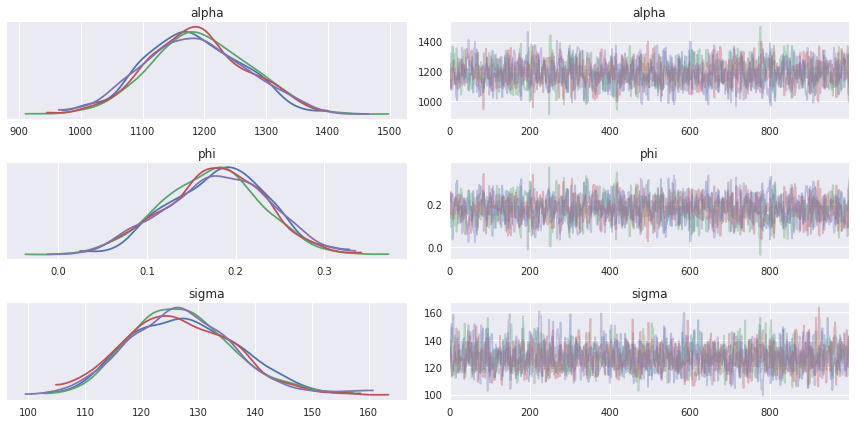

In [ ]:
az.plot_trace(ar1_fit_data, 
              var_names=["alpha", "phi", "sigma"], 
              compact=False)
plt.tight_layout()
plt.show()

### Perform prediction

(4000, 150)


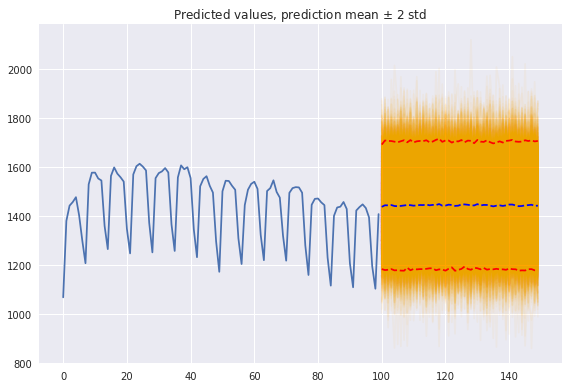

In [ ]:
# I collect the predictions all of iterations of all 4 chains for each time t
# for each t, I plot all the n_chains*N_iter samples of y(t) in order to show the whole zone where the 
# model predicted the output

preds = ar1_fit_data.posterior.y_pred.values.reshape((4 * N_iter, len(data)+N_pred))
print(preds.shape) # for each time t, I have a vector of n_chains*N_iter of y(t)

preds_std = np.std(preds, axis = 0) # standard deviation of the prediction for each time t
preds_mean = np.mean(preds, axis = 0)
preds_std = np.column_stack((preds_mean-2*preds_std, preds_mean+2*preds_std))

fig, ax = plt.subplots(1,1)
ax.plot(data)
tnew = len(data) + np.arange(N_pred)
ax.plot(tnew, preds[:, -N_pred:].T, color="orange", alpha=0.05)
ax.plot(tnew, preds_mean[-N_pred:], color='blue', linestyle='--')
ax.plot(tnew, preds_std[-N_pred:, :], color='red', linestyle='--')  ## plot mean +- std of prediction of y(t)
ax.set_title('Predicted values, prediction mean $\pm$ 2 std')
plt.tight_layout()
plt.show()

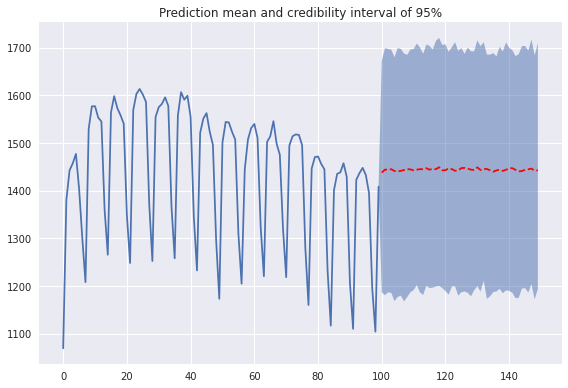

In [ ]:
# extract the values in the credibility interval of 95% and visulize
hdis = az.hdi(ar1_fit_data.posterior.y_pred.values, hdi_prob=0.95)
preds_mean = np.mean(preds, axis = 0)

fig, ax = plt.subplots(1,1)
ax.plot(data)
tnew = len(data) + np.arange(N_pred)
ax.fill_between(np.arange(hdis.shape[0]), hdis[:, 0], hdis[:, 1], alpha=0.5)
ax.plot(tnew, preds_mean[-N_pred:], color='red', linestyle='--')
ax.set_title('Prediction mean and credibility interval of 95%')
plt.tight_layout()

## Autoregressive order 10

### Settings

In [ ]:
N_pred = 50
ar10_data = {
    "N": len(data),
    "p": 10,            # order 10
    "y": data,
    "N_pred": N_pred   # number of predictions
}
N_iter = 1000
ar_10_fit = ar_p.sample(data=ar10_data, chains=4, parallel_chains=4, seed=stan_seed,
    iter_warmup=1000, iter_sampling=N_iter, thin = 1, show_progress=True)

ar10_fit_data = az.from_cmdstanpy(ar_10_fit)

Chain 1 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]

Chain 1 - warmup:   0%|                                                                        | 0/2000 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|                                                                        | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|                                                                        | 0/2000 [00:00<?, ?it/s]


Chain 4 - warmup:   0%|                                                                           | 0/1 [00:00<?, ?it/s]


Chain 1 - warmup:   5%|███                                                          | 100/2000 [00:00<00:08, 227.78it/s]

Chain 3 - warmup:   5%|███                                                          | 100/2000 [00:00<00:09, 203.64it/s]


Chain 2 - warmup:  1

### Visualize the results

In [ ]:
az.summary(ar10_fit_data)

/home/carlo/python_env/bayes_env/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,807.333,102.997,621.749,1007.510,2.142,1.515,2322.0,2683.0,1.0
phi[0],0.474,0.172,0.151,0.792,0.004,0.003,2105.0,1780.0,1.0
phi[1],0.153,0.193,-0.215,0.508,0.005,0.003,1695.0,1802.0,1.0
phi[2],0.059,0.161,-0.237,0.368,0.003,0.003,2221.0,2331.0,1.0
phi[3],-0.060,0.046,-0.148,0.022,0.001,0.001,2531.0,2476.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[145],1504.854,330.173,1227.180,1774.970,5.021,3.650,3963.0,3397.0,1.0
y_pred[146],1264.476,298.544,1007.480,1553.680,4.395,3.275,4091.0,3851.0,1.0
y_pred[147],1171.718,264.661,878.712,1455.630,3.872,2.857,3706.0,3813.0,1.0
y_pred[148],1411.407,248.281,1140.730,1728.990,3.949,2.792,3913.0,3458.0,1.0


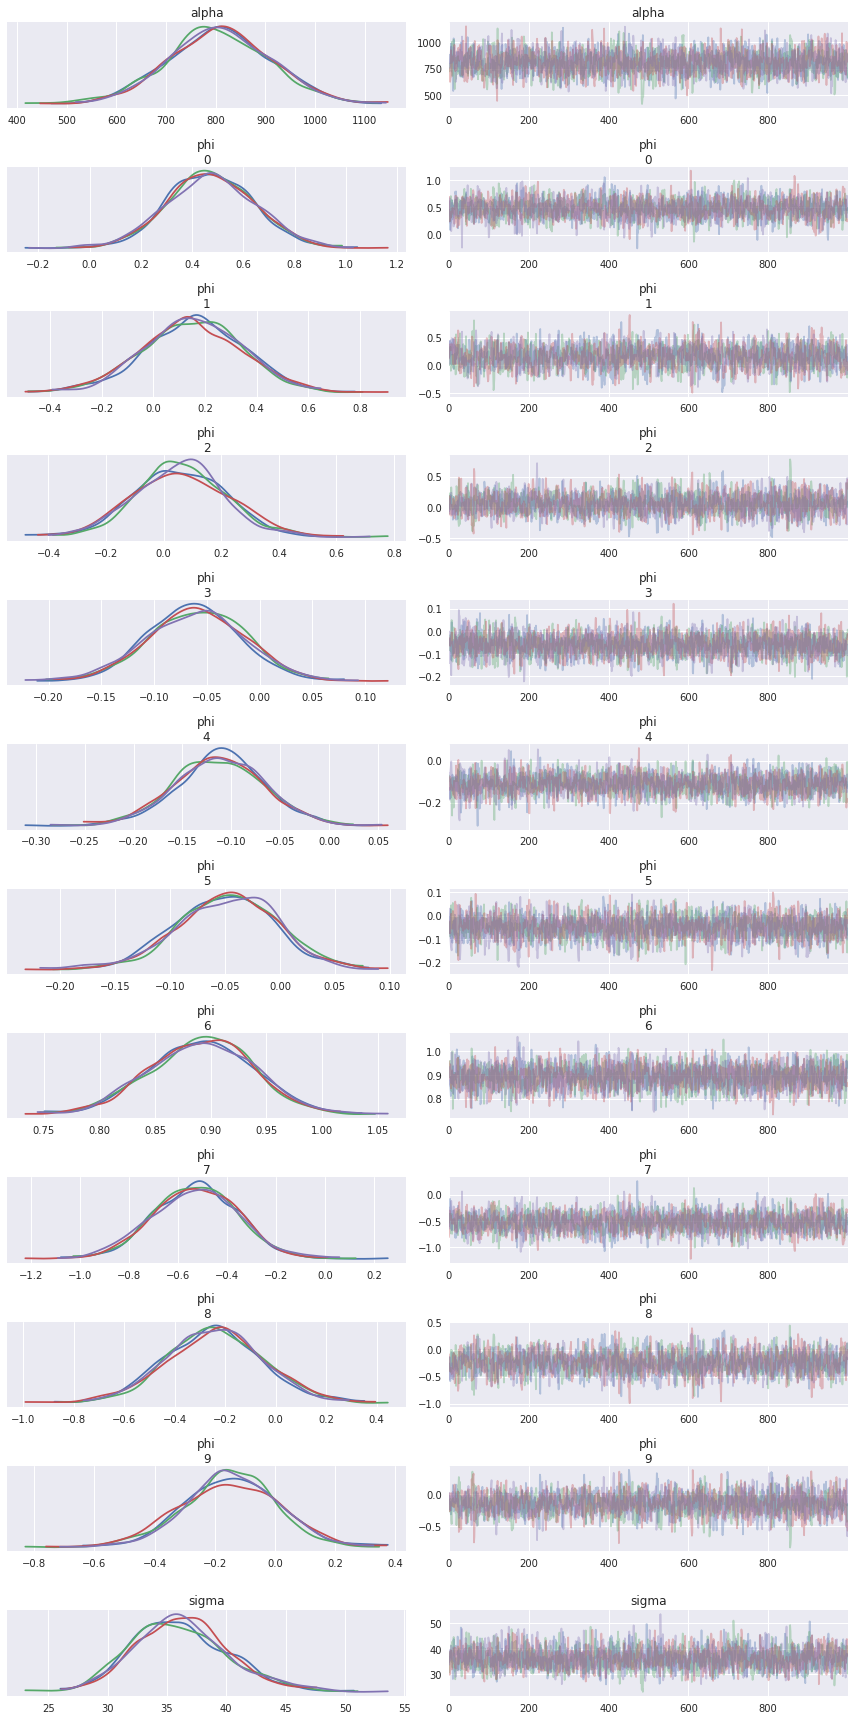

In [ ]:
az.plot_trace(ar10_fit_data, 
              var_names=["alpha", "phi", "sigma"], 
              compact=False)
plt.tight_layout()
plt.show()

### Perform prediction

(4000, 150)


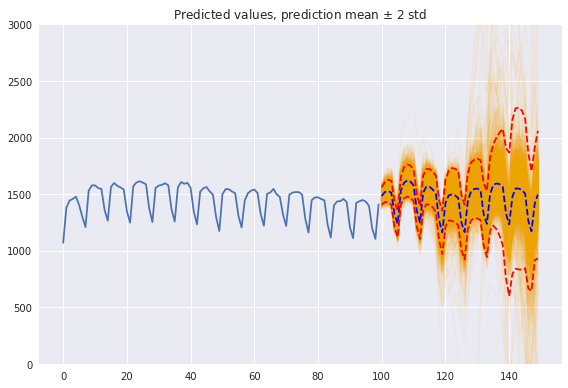

In [ ]:
preds = ar10_fit_data.posterior.y_pred.values.reshape((4 * N_iter, len(data)+N_pred))
print(preds.shape) # for each time t, I have a vector of n_chains*N_iter of y(t)

preds_std = np.std(preds, axis = 0) # standard deviation of the prediction for each time t
preds_mean = np.mean(preds, axis = 0)
preds_std = np.column_stack((preds_mean-2*preds_std, preds_mean+2*preds_std))

fig, ax = plt.subplots(1,1)
ax.plot(data)
tnew = len(data) + np.arange(N_pred)
ax.plot(tnew, preds[:, -N_pred:].T, color="orange", alpha=0.05)
ax.plot(tnew, preds_mean[-N_pred:], color='blue', linestyle='--')
ax.plot(tnew, preds_std[-N_pred:, :], color='red', linestyle='--')  ## plot mean +- std of prediction of y(t)
ax.set_ylim((0, 3000))
ax.set_title('Predicted values, prediction mean $\pm$ 2 std')
plt.tight_layout()
plt.show()

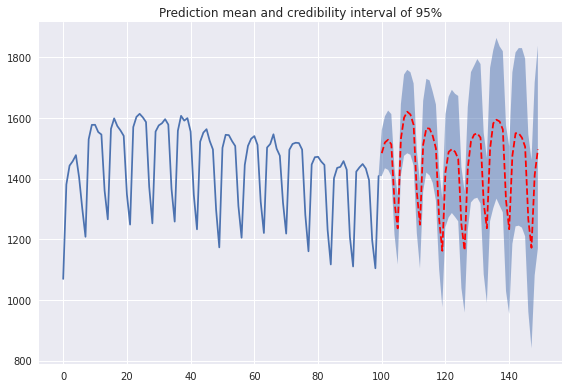

In [ ]:
# extract the values in the credibility interval of 95% and visulize
hdis = az.hdi(ar10_fit_data.posterior.y_pred.values, hdi_prob=0.95)
preds_mean = np.mean(preds, axis = 0)

fig, ax = plt.subplots(1,1)
ax.plot(data)
tnew = len(data) + np.arange(N_pred)
ax.fill_between(np.arange(hdis.shape[0]), hdis[:, 0], hdis[:, 1], alpha=0.5)
ax.plot(tnew, preds_mean[-N_pred:], color='red', linestyle='--')
ax.set_title('Prediction mean and credibility interval of 95%')
plt.tight_layout()
plt.show()